In [ ]:

%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
try :
    from google.colab import drive
    from pathlib import Path
    import os

    # Montar Drive
    drive.mount('/content/drive')

    # Rutas posibles
    paths = [
        "/content/drive/MyDrive/Proyecto_final",
        "/content/drive/MyDrive/Accesos directos/Proyecto_final",
        "/content/drive/MyDrive/Shortcuts/Proyecto_final"
    ]


    # Buscar cuál existe
    for p in paths:
        if Path(p).exists():
            BASE_DIR = Path(p)
            print(f"✅ Proyecto encontrado en: {BASE_DIR}")
            os.chdir(BASE_DIR)
            break
    else:
        raise FileNotFoundError("⚠️ No se encontró la carpeta TP_Colorizacion. Revisá el nombre del acceso directo.")

    # Confirmar contenido
    print("📁 Archivos encontrados:")
    for f in list(BASE_DIR.iterdir())[:10]:
        print("  ", f.name)
    DATA_DIR = Path("/content/imagewoof2-160")

except ImportError:
    DATA_DIR = Path("/imagewoof2-160")

    print("Entorno local detectado.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Proyecto encontrado en: /content/drive/MyDrive/Proyecto_final
📁 Archivos encontrados:
   imagewoof2-160
   README.md
   __pycache__
   utils
   models
   .git
   pesos_entrenados
   final.ipynb


In [6]:
!rm -rf /content/imagewoof2-160  # limpia si existía
!cp -r "/content/drive/MyDrive/Proyecto_final/imagewoof2-160" /content/


In [7]:
import torch
print("CUDA disponible:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
!nvidia-smi


CUDA disponible: True
GPU: Tesla T4
Tue Nov 11 16:23:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------

In [8]:
# =============================================
# Preparación del dataset Imagewoof para colorización
# =============================================
import os
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from skimage.color import rgb2lab, lab2rgb
from PIL import Image
import matplotlib.pyplot as plt
from utils.utils import ImagewoofColorizationDataset




In [9]:
DATA_DIR = Path("/content/imagewoof2-160")


# ---------------------------------------------
# Crear datasets
# ---------------------------------------------
train_dataset = ImagewoofColorizationDataset(DATA_DIR, split="train")
val_dataset   = ImagewoofColorizationDataset(DATA_DIR, split="val")

# ---------------------------------------------
# Crear DataLoaders (sin multiprocessing)
# ---------------------------------------------
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)


In [10]:


print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")

# ---------------------------------------------
# Probar una muestra del DataLoader
# ---------------------------------------------
L_batch, ab_batch = next(iter(train_loader))
print("Shape canal L:", L_batch.shape)   # [batch, 1, H, W]
print("Shape canales ab:", ab_batch.shape)  # [batch, 2, H, W]


Train samples: 9025
Val samples: 3929
Shape canal L: torch.Size([16, 1, 224, 224])
Shape canales ab: torch.Size([16, 2, 224, 224])


In [11]:
DATA_DIR = Path("imagewoof2-160")


# ---------------------------------------------
# Crear datasets
# ---------------------------------------------
train_dataset = ImagewoofColorizationDataset(DATA_DIR, split="train")
val_dataset   = ImagewoofColorizationDataset(DATA_DIR, split="val")

# ---------------------------------------------
# Crear DataLoaders (sin multiprocessing)
# ---------------------------------------------
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)


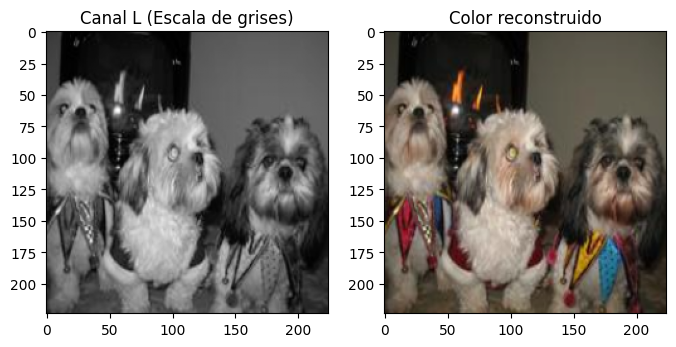

In [12]:
# ---------------------------------------------
# Visualizar una muestra reconstruida (opcional)
# ---------------------------------------------
L_sample = L_batch[2]
ab_sample = ab_batch[2]

# Reconstruir imagen RGB aproximada
lab = torch.cat((L_sample, ab_sample), dim=0).permute(1, 2, 0).numpy()
rgb = lab2rgb(lab * [100, 128, 128])

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(L_sample.squeeze(), cmap='gray')
plt.title("Canal L (Escala de grises)")

plt.subplot(1,2,2)
plt.imshow(rgb)
plt.title("Color reconstruido")
plt.show()


ENCODER

In [13]:
import torch.optim as optim
from tqdm import tqdm
from models.encoder import FastColorNet
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando:", device)

# Redimensionar imágenes a 128×128 para acelerar
train_dataset = ImagewoofColorizationDataset(DATA_DIR, img_size=128, split="train")
val_dataset   = ImagewoofColorizationDataset(DATA_DIR, img_size=128, split="val")

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)


Usando: cuda


In [15]:
!pip install pytorch-msssim


In [16]:
from utils.trainer import trainer


# Configuración del modelo y ruta
model = FastColorNet()
save_path = "pesos_entrenados"
save_name = "fastColorNet.pt"
model_path = Path(save_path) / save_name

train= False  # Cambia a True para forzar el reentrenamiento

# Verificar si ya existe un modelo entrenado
if model_path.exists and not train:
    print(f"✅ Modelo ya entrenado encontrado en '{model_path}'.")
    print("No se vuelve a entrenar para evitar sobreescritura.")
else:
    print("🚀 No se encontró modelo entrenado, iniciando entrenamiento...")
    trainer(
        model,
        train_loader,
        val_loader,
        epochs=10,
        save_path=save_path,
        save_name=save_name
    )
    print(f"💾 Modelo guardado en: {model_path}")

✅ Modelo ya entrenado encontrado en 'pesos_entrenados/fastColorNet.pt'.
No se vuelve a entrenar para evitar sobreescritura.


In [17]:
from utils.visualize import visualize_colorization, visualize_ranked_colorizations
# Cargar mejor modelo si hace falta
model = FastColorNet()
model.load_state_dict(torch.load("pesos_entrenados/fastColorNet.pt"))


# Visualizar resultados
visualize_colorization(model, val_loader, num_samples=5)

visualize_ranked_colorizations(model, val_loader, num_each=3, criterion=nn.L1Loss(reduction="none"))


Output hidden; open in https://colab.research.google.com to view.

In [19]:
from models.unet import UNetColor


# Configuración del modelo y ruta
model = UNetColor()
save_path = "pesos_entrenados"
save_name = "unetColor.pt"
model_path = Path(save_path) / save_name

train= False  # Cambia a True para forzar el reentrenamiento

# Verificar si ya existe un modelo entrenado
if model_path.exists and not train:
    print(f"✅ Modelo ya entrenado encontrado en '{model_path}'.")
    print("No se vuelve a entrenar para evitar sobreescritura.")
else:
    print("🚀 No se encontró modelo entrenado, iniciando entrenamiento...")
    trainer(
        model,
        train_loader,
        val_loader,
        epochs=10,
        save_path=save_path,
        save_name=save_name
    )
    print(f"💾 Modelo guardado en: {model_path}")

✅ Modelo ya entrenado encontrado en 'pesos_entrenados/unetColor.pt'.
No se vuelve a entrenar para evitar sobreescritura.


In [20]:
model = UNetColor()
model.load_state_dict(torch.load("pesos_entrenados/unetColor.pt"))


visualize_colorization(model, val_loader, num_samples=5)

visualize_ranked_colorizations(model, val_loader, num_each=3, criterion=nn.L1Loss(reduction="none"))


Output hidden; open in https://colab.research.google.com to view.

In [24]:

# Configuración del modelo y ruta
model = UNetColor()
save_path = "pesos_entrenados"
save_name = "unetColorSSIM.pt"
model_path = Path(save_path) / save_name

train= False  # Cambia a True para forzar el reentrenamiento

# Verificar si ya existe un modelo entrenado
if model_path.exists and not train:
    print(f"✅ Modelo ya entrenado encontrado en '{model_path}'.")
    print("No se vuelve a entrenar para evitar sobreescritura.")
else:
    print("🚀 No se encontró modelo entrenado, iniciando entrenamiento...")
    trainer(
        model,
        train_loader,
        val_loader,
        epochs=10,
        save_path=save_path,
        save_name=save_name,
        criterion='combined'

    )
    print(f"💾 Modelo guardado en: {model_path}")

/content/drive/Othercomputers/My Mac/Proyecto_final/utils/trainer.py:70: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))


🚀 No se encontró modelo entrenado, iniciando entrenamiento...
Entrenando en: cuda
Usando criterio: combined


Época 1/10:   0%|          | 0/1129 [00:00<?, ?it/s]/content/drive/Othercomputers/My Mac/Proyecto_final/utils/trainer.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
Época 1/10: 100%|██████████| 1129/1129 [01:35<00:00, 11.78it/s, loss=0.2265]


Época 01 | Train Loss: 0.1817 | Val Loss: 0.1875
✅ Nuevo mejor modelo guardado (Val Loss=0.1875)


Época 2/10:   5%|▍         | 56/1129 [00:04<01:33, 11.51it/s, loss=0.1610]


KeyboardInterrupt: 

In [22]:
model = UNetColor()
model.load_state_dict(torch.load("pesos_entrenados/unetColorSSIM.pt"))


visualize_colorization(model, val_loader, num_samples=5)

visualize_ranked_colorizations(model, val_loader, num_each=3, criterion=nn.L1Loss(reduction="none"))


In [ ]:
import os
import shutil
from pathlib import Path

# --- Configuración de carpetas ---
LOCAL_SAVE_DIR = Path("/content/pesos_entrenados")
RESULTS_DIR = Path("/content/resultados")

DRIVE_SAVE_DIR = Path("/content/drive/MyDrive/Proyecto_final/pesos_entrenados")
DRIVE_RESULTS_DIR = Path("/content/drive/MyDrive/Proyecto_final/resultados")

def backup_to_drive():
    """
    Copia los modelos y resultados desde el almacenamiento local (/content/)
    al Google Drive del proyecto.
    """
    # Crear carpetas destino si no existen
    DRIVE_SAVE_DIR.mkdir(parents=True, exist_ok=True)
    DRIVE_RESULTS_DIR.mkdir(parents=True, exist_ok=True)

    # Copiar modelos entrenados
    if LOCAL_SAVE_DIR.exists():
        print(f"📤 Copiando modelos desde {LOCAL_SAVE_DIR} → {DRIVE_SAVE_DIR}")
        for file in LOCAL_SAVE_DIR.glob("*.pt"):
            shutil.copy(file, DRIVE_SAVE_DIR)
            print(f"   ✅ {file.name} guardado en Drive")

    # Copiar resultados (gráficos, imágenes, etc.)
    if RESULTS_DIR.exists():
        print(f"📸 Copiando resultados desde {RESULTS_DIR} → {DRIVE_RESULTS_DIR}")
        for file in RESULTS_DIR.glob("*"):
            shutil.copy(file, DRIVE_RESULTS_DIR / file.name)
            print(f"   ✅ {file.name} guardado en Drive")

    print("✅ Backup completo en Google Drive.")

# --- Ejecutar al final del entrenamiento ---
backup_to_drive()
